In [10]:
using Pkg
Pkg.activate("../.")
using MuJoCo 
using MeshCat
using MeshCatMechanisms
using DelimitedFiles
using TOML
using Pkg 
using RigidBodyDynamics 
using Rotations: rotation_error, CayleyMap, UnitQuaternion 
using StaticArrays
using ForwardDiff
using LinearAlgebra
using Rotations
using PyPlot 
using QuadrupedBalance

  Activating environment at `~/dev/16715-dynamics/QuadrupedBalance/Project.toml`
┌ Info: Precompiling QuadrupedBalance [701d57af-faf8-455d-a833-a69eed6154c2]
└ @ Base loading.jl:1342
┌ Warning: Package QuadrupedBalance does not have LinearAlgebra in its dependencies:
│ - If you have QuadrupedBalance checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QuadrupedBalance
└ Loading LinearAlgebra into QuadrupedBalance from project dependency, future warnings for QuadrupedBalance are suppressed.


In [18]:
## Mujoco helper functions 
function get_state(mj_data)
    x = zeros(37)
    q = mj_data.qpos
    q̇ = mj_data.qvel
    x[1:4] = q[4:7] 
    x[5:7] = q[1:3]
    x[20:22] = q̇[4:6]
    x[23:25] = q̇[1:3]
    x[8:19] = QuadrupedBalance.mapMotorArrays(q[8:19], QuadrupedBalance.MotorIDs_c, QuadrupedBalance.MotorIDs_rgb)
    x[26:37] = QuadrupedBalance.mapMotorArrays(q̇[7:end], QuadrupedBalance.MotorIDs_c, QuadrupedBalance.MotorIDs_rgb)
    return x 
end 

function get_sensor(mj_data)
    sensor_data = mj_data.sensordata
    acc = sensor_data[1:3]
    ω = sensor_data[4:6]
    encoders = sensor_data[7:18]
    vels = sensor_data[19:30]
    touches = sensor_data[31:end]
    return acc, ω, encoders, vels, touches
end 

function set_state!(muj_data, x)
    muj_data.qpos[1:3] = x[5:7]
    muj_data.qpos[4:7] = x[1:4]
    muj_data.qpos[8:19] = QuadrupedBalance.mapMotorArrays(x[8:19], QuadrupedBalance.MotorIDs_rgb, QuadrupedBalance.MotorIDs_c)  
    muj_data.qvel[1:3] = x[23:25]
    muj_data.qvel[4:6] = x[20:22]
end 

function joint_linear_interpolation(q_start, q_target, rate)
    q_now = q_start * (1-rate) + q_target * rate 
    return q_now 
end 

function joint_pd_control(q, q_des, q_v, Kp, Kd)
    q_diff = q - q_des 
    u = -Kp .* q_diff - Kd .* q_v 
end 

joint_pd_control (generic function with 1 method)

In [132]:
URDFPATH = joinpath(@__DIR__, "..", "src","a1","urdf","a1.urdf")
data = TOML.parsefile("ipopt_eq_point.toml")
x_init = TOML.parsefile("resting.toml")["x_init"]

x_eq = data["x_eq"]
uf = data["u_eq"]
λf = data["λ_eq"];

# Configure the state in the standing pose 
q_stand = x_eq[8:19]
q_stand[2:3] .= q_stand[1]
q_stand[6:7] .= q_stand[5]
q_stand[10:11] .= q_stand[9]

In [616]:
### Initializing simulator 
A1mech = parse_urdf(URDFPATH, floating=true, remove_fixed_tree_joints=false)
A1 = QuadrupedBalance.UnitreeA1FullBody(A1mech)
mujoco_model = jlModel("../src/a1/urdf/a1.xml")
mujoco_data = jlData(mujoco_model)
h_sim = mujoco_model.opt.timestep
tf = 6.0
times = 0:h_sim:tf
set_state!(mujoco_data, x_init); mj_step(mujoco_model, mujoco_data);
rate_count = 0  

K = readdlm("maximal_lqr_gain.txt", '\t', Float64, '\n')
x_err = zeros(36)
xs = zeros(length(times), 37)
x_errs = zeros(length(times), 36)
us = zeros(length(times), 12);

for i = 1:length(times)
    global rate_count, q_stand
    global acc, ω, encs, vels, touches, err_int
    ## get sensor data 
    acc, ω, encs, vels, touches = get_sensor(mujoco_data)
    encs = QuadrupedBalance.mapMotorArrays(encs, QuadrupedBalance.MotorIDs_c, QuadrupedBalance.MotorIDs_rgb)
    vels = QuadrupedBalance.mapMotorArrays(vels, QuadrupedBalance.MotorIDs_c, QuadrupedBalance.MotorIDs_rgb) 
    
    ## ground truth state 
    x = get_state(mujoco_data) 
    quat_meas = UnitQuaternion(x[1:4])
    p = QuadrupedBalance.fk(encs)
    com_pos = x[5:7] 
    p_RL_foot = quat_meas * p[10:12] + com_pos
    p_FR_foot = quat_meas * p[1:3] + com_pos
    p_support = p_FR_foot[1:2] - p_RL_foot[1:2]
    P_project = p_support * p_support' / (p_support' * p_support)

    ## calc error and control  
    if (rate_count < 3000)
        rate_count+=1 
        rate = rate_count > 2000 ? 1  : (rate_count / 2000)
        q_des = joint_linear_interpolation(x_init[8:19], q_stand, rate)
        u = joint_pd_control(x[8:19], q_des, x[26:end], 100, 0)
    else 
        quat_meas = UnitQuaternion(x[1:4])
        quat_eq = UnitQuaternion(x_init[1:4])
        θ_err = rotation_error(quat_meas, quat_eq, Rotations.CayleyMap()) 

        # Position error 
        eq_point = (p_FR_foot[1:2] + p_RL_foot[1:2])/2.0
        x_err[4:5] =  quat_eq[1:2,1:2]' * (com_pos[1:2] - eq_point) #- (quat_meas' * ([0.01, 0.0, 0.0]))[1:2]
        x_err[6] = (x[7] - x_eq[7])
        
        x_err[1:3] = θ_err 
        x_err[7:18] = encs - x_eq[8:19]
        x_err[19:21] = ω 
        x_err[22:23] = quat_eq[1:2,1:2]' * x[23:24] 
        x_err[24] = x[25] 
        x_err[25:36] = vels
        
        ## Attitude and joint errors 
#         x_err[1:3] = θ_err
#         x_err[4:15] = encs - x_eq[8:19]
#         x_err[16:18] = ω 
#         x_err[19:30] = vels
         
        u = -K*x_err + uf
        us[i,:] = u  
    end 

    xs[i,:] = x 
    x_errs[i,:] = x_err 

    ## setting control and simulate a step
    mujoco_data.ctrl[:] = QuadrupedBalance.mapMotorArrays(u, QuadrupedBalance.MotorIDs_rgb, QuadrupedBalance.MotorIDs_c)
    mj_step(mujoco_model, mujoco_data)
end 

In [535]:
vis = Visualizer() 
cur_path = pwd()
cd(joinpath(@__DIR__,"..","src", "a1", "urdf"))
mvis = MechanismVisualizer(A1mech, URDFVisuals(URDFPATH), vis)
cd(cur_path)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat /Users/chiyenlee/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


In [617]:
q_anim = [xs[i,1:19] for i in 1:length(times)-1]
animation = Animation(mvis, times[1:50:end-1], q_anim[1:50:end])
setanimation!(mvis, animation);

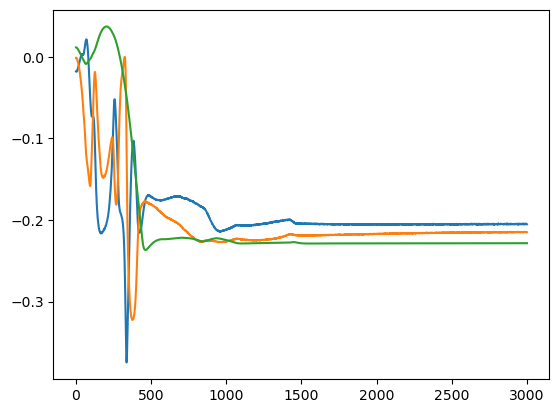

3-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f87730deb80>
 PyObject <matplotlib.lines.Line2D object at 0x7f87730debb0>
 PyObject <matplotlib.lines.Line2D object at 0x7f87730decd0>

In [609]:
plot(x_errs[3001:end,4:6])

In [615]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x77, 0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("trunk" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x62, 0x61, 0x73, 0x65, 0x2f, 0x74, 0x72, 0x75, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_floating_base" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x74, 0x69, 0x6e, 0x67, 0x5f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RL_hip" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x75, 0x6e, 0x6b, 0x2f, 0x52, 0x4c, 0x5f, 0x68, 0x69, 0x70], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RL_thigh" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x2f, 0x52, 0x4c, 0x5f, 0x74, 0x68, 0x69, 0x67, 0x68], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RL_thigh_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x69, 0x67, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_17" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RL_calf" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x68, 0x2f, 0x52, 0x4c, 0x5f, 0x63, 0x61, 0x6c, 0x66], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RL_foot" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6c, 0x66, 0x2f, 0x52, 0x4c, 0x5f, 0x66, 0x6f, 0x6f, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RL_foot_fixed" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x66, 0x69, 0x78, 0x65, 0x64], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x39], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72,